# 1 - Prepare data

In [1]:
import pandas as pd
import numpy as np
import datetime as date
import matplotlib.pyplot as plt
import time

In [2]:
#Retrieve data from hospital.csv
df = pd.read_csv('https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/hospital.csv')
df  = df.groupby('date').sum()
df['date'] = pd.date_range('2020-03-24', periods=890, freq='D')
mask = (df['date'] > '2021-5-31') & (df['date'] <= '2022-1-31')
hospital = df.loc[mask][['beds_covid','beds','admitted_total','hosp_covid','hosp_pui']]
hospital

,beds_covid,beds,admitted_total,hosp_covid,hosp_pui
date,,,,,
2021-06-01,10730,38285,1994,7676,1280
2021-06-02,10824,38318,1875,7587,1175
2021-06-03,10813,38318,1906,7565,1247
2021-06-04,10871,38318,1833,7337,1191
2021-06-05,10896,38318,1992,7457,1082
...,...,...,...,...,...
2022-01-27,9877,40899,964,2002,888
2022-01-28,9794,40827,955,1844,850
2022-01-29,9781,40827,890,2036,912


In [3]:
#Retrieve data from icu.csv
icu_initial = pd.read_csv('https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/icu.csv')
icu_initial  = icu_initial.groupby('date').sum()
icu_initial['date'] = pd.date_range('2020-03-24',periods=890, freq='D')
mask = (icu_initial['date'] > '2021-5-31') & (icu_initial['date'] <= '2022-1-31')
icu = icu_initial.loc[mask][['icu_covid','beds_icu_covid','icu_pui']]
icu

,icu_covid,beds_icu_covid,icu_pui
date,,,
2021-06-01,1181,1126,9
2021-06-02,1202,1124,11
2021-06-03,1176,1124,14
2021-06-04,1154,1126,11
2021-06-05,1155,1132,12
...,...,...,...
2022-01-27,124,859,0
2022-01-28,127,859,0
2022-01-29,119,859,0


In [4]:
#Combine 2 dataframe into 1
totalFeatures = pd.merge(hospital, icu, on = "date")
print("The resultant DataFrame:")
totalFeatures

The resultant DataFrame:


,beds_covid,beds,admitted_total,hosp_covid,hosp_pui,icu_covid,beds_icu_covid,icu_pui
date,,,,,,,,
2021-06-01,10730,38285,1994,7676,1280,1181,1126,9
2021-06-02,10824,38318,1875,7587,1175,1202,1124,11
2021-06-03,10813,38318,1906,7565,1247,1176,1124,14
2021-06-04,10871,38318,1833,7337,1191,1154,1126,11
2021-06-05,10896,38318,1992,7457,1082,1155,1132,12
...,...,...,...,...,...,...,...,...
2022-01-27,9877,40899,964,2002,888,124,859,0
2022-01-28,9794,40827,955,1844,850,127,859,0
2022-01-29,9781,40827,890,2036,912,119,859,0


In [5]:
# Convert the dataframe to array and join both of the array to combine data
totalFeaturesArray = totalFeatures.to_numpy()
totalFeaturesArray

array([[10730, 38285,  1994, ...,  1181,  1126,     9],
       [10824, 38318,  1875, ...,  1202,  1124,    11],
       [10813, 38318,  1906, ...,  1176,  1124,    14],
       ...,
       [ 9781, 40827,   890, ...,   119,   859,     0],
       [ 9781, 40827,   901, ...,   120,   852,     0],
       [ 9723, 40837,   864, ...,   114,   852,     0]], dtype=int64)

In [6]:
# Determine multicollinearlity of features (To detmine which models to use)

from statsmodels.stats.outliers_influence import variance_inflation_factor

features_VIF = np.delete(totalFeaturesArray,[0], axis=1).astype('int64')
features_VIF = pd.DataFrame(features_VIF, columns = ['beds','admitted_total', 'hosp_covid', 'hosp_pui', 'icu_covid', 'beds_icu_covid', 'icu_pui'])

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(features_VIF.values, i) for i in range(features_VIF.shape[1])]
vif["features"] = features_VIF.columns

vif.round(1) # High correlation, can choose regression model like Ridge, Lasso

,VIF Factor,features
0,109.9,beds
1,179.1,admitted_total
2,148.2,hosp_covid
3,127.2,hosp_pui
4,53.1,icu_covid
5,259.2,beds_icu_covid
6,5.2,icu_pui


# Preprocessing Data

In [7]:
#Scale the feature values to between 1 and 10
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(1,10))
scaler.fit(totalFeatures)
scaled_features = scaler.transform(totalFeatures)

In [8]:
scaled_features = pd.DataFrame(scaled_features, columns = ['beds_covid','beds','admitted_total', 'hosp_covid', 'hosp_pui', 'icu_covid', 'beds_icu_covid', 'icu_pui'])
scaled_features
scaled_features_array = scaled_features.to_numpy()

In [9]:
scaled_features = scaled_features.drop(columns=['beds_covid'])
scaled_features

,beds,admitted_total,hosp_covid,hosp_pui,icu_covid,beds_icu_covid,icu_pui
0,1.000000,5.735902,5.093367,5.227692,7.492901,4.210938,2.0125
1,1.061023,5.310564,5.031662,4.258462,7.620690,4.187500,2.2375
2,1.061023,5.421366,5.016409,4.923077,7.462475,4.187500,2.5750
3,1.061023,5.160445,4.858331,4.406154,7.328600,4.210938,2.2375
4,1.061023,5.728753,4.941530,3.400000,7.334686,4.281250,2.3500
...,...,...,...,...,...,...,...
240,5.833779,2.054408,1.159464,1.609231,1.060852,1.082031,1.0000
241,5.700637,2.022240,1.049919,1.258462,1.079108,1.082031,1.0000
242,5.700637,1.789913,1.183037,1.830769,1.030426,1.082031,1.0000
243,5.700637,1.829230,1.206610,1.969231,1.036511,1.000000,1.0000


In [10]:
#Set the target feature(beds_covid)
target = scaled_features_array[:, [0]]
target = target.ravel()
target

array([ 1.98908654,  2.08141438,  2.07061006,  2.1275783 ,  2.15213358,
        2.28571429,  2.2955364 ,  2.30535851,  2.633417  ,  2.67663429,
        2.80432173,  2.78664193,  2.84164575,  2.84164575,  2.95460002,
        2.92316927,  2.9261159 ,  2.93593801,  2.86325439,  3.05674997,
        3.02924806,  3.06362545,  3.08523409,  3.06362545,  3.03121248,
        3.03514133,  3.14318455,  3.22372585,  3.21783259,  3.2276547 ,
        3.25810324,  3.26596093,  3.39266616,  3.45749209,  3.64607661,
        3.76197752,  3.79635491,  3.89555822,  3.96922405,  4.08414275,
        4.21870566,  4.24424315,  4.31201572,  4.29924697,  4.29433592,
        4.8699116 ,  4.94455964,  5.11546437,  5.19011241,  5.25493834,
        5.2785114 ,  5.83935392,  6.05445815,  6.22929172,  6.27152679,
        6.43555604,  6.68601986,  7.0710466 ,  7.1329259 ,  7.39615846,
        7.46687766,  7.59751173,  7.74877224,  8.02182691,  8.13674561,
        8.38720943,  8.5532031 ,  8.57186511,  8.61802903,  8.77

# Split dataset into training and testing

In [11]:
from sklearn.model_selection import train_test_split
# Create train test split
x_train, x_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.3)

# Ridge Regression

In [12]:
from sklearn.linear_model import Ridge
regr = Ridge(alpha=1)
regr.fit(x_train, y_train)
print(regr.score(x_test, y_test))

0.9603112204096881


time passed : 
0.002004384994506836


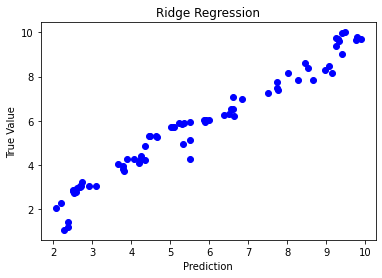

In [13]:
start = time.time()
y_pred = regr.predict(x_test)
end = time.time()
RidgeSpeed = end - start
print('time passed : ')
print(RidgeSpeed)
plt.scatter(y_pred, y_test, color ='b')
plt.xlabel('Prediction')
plt.ylabel('True Value')
plt.title("Ridge Regression")
plt.show()

# Cross Validation to prevent overfitting

In [14]:
from sklearn.model_selection import KFold, cross_val_score

k_folds = KFold(n_splits = 5)

scores = cross_val_score(regr, x_test, y_test, cv = k_folds)

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores:  [0.93188201 0.98004228 0.92792515 0.95897378 0.9579049 ]
Average CV Score:  0.9513456265732916
Number of CV Scores used in Average:  5


# Random Forest Regressor

In [15]:
from sklearn.ensemble import RandomForestRegressor
fregr = RandomForestRegressor()
y_train = y_train.ravel()
fregr.fit(x_train, y_train)
print(fregr.score(x_test, y_test))

0.9913465942700009


time passed : 
0.013041973114013672


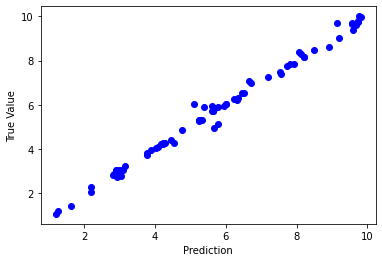

In [16]:
start = time.time()
y_pred = fregr.predict(x_test)
end = time.time()
RandomForestSpeed = end - start
print('time passed : ')
print(RandomForestSpeed)
plt.scatter(y_pred, y_test, color ='b')
plt.xlabel('Prediction')
plt.ylabel('True Value')
plt.show()

# Cross Validation to prevent overfitting

In [17]:
from sklearn.model_selection import KFold, cross_val_score

k_folds = KFold(n_splits = 5)

scores = cross_val_score(fregr, x_test, y_test, cv = k_folds)

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores:  [0.98451098 0.981458   0.97867056 0.9921552  0.97904534]
Average CV Score:  0.9831680170417606
Number of CV Scores used in Average:  5


In [18]:
print('Time comparison')
print('Ridge :')
print(RidgeSpeed)
print('Random Forest :')
print(RandomForestSpeed)

Time comparison
Ridge :
0.002004384994506836
Random Forest :
0.013041973114013672
